In [31]:
import pandas as pd
import numpy as np
from astropy.timeseries import TimeSeries
from astropy.timeseries import BoxLeastSquares
import astropy.units as u
from astropy.time import Time
import lightkurve as lk
import matplotlib.pyplot as plt
import glob
from typing import Dict
import pickle
from download_lightcurves import download_dr3_lightcurve
from tess import download_lc

In [14]:
CLUSTER_NAME: str = 'NGC 188'

In [15]:
def mag_error(flux_over_error: float) -> float:
    return 1/(flux_over_error*2.5/np.log(10))


def gaia_time_to_bjd(tcb_time: float) -> float:
    return tcb_time + 2455197.5

def create_timeseries(lc: pd.DataFrame) -> TimeSeries:
    return TimeSeries(data={'flux': lc.flux.values},
                      time=Time(lc.time.values*u.day,
                                format='jd'))

def periodogram(lc: pd.DataFrame, start_period, end_period, periods=500): 
    model = BoxLeastSquares(lc.time.values*u.day, lc.flux.values)
    periods = np.linspace(start_period, end_period, periods)*u.day
    periodogram = model.power(periods, start_period/2)
    return periodogram

def plot_periodogram(periodogram):
    plt.figure();
    plt.plot(periodogram.period, periodogram.power, color='royalblue');
    plt.gca().set_xlabel('Period [d]')
    plt.gca().set_ylabel('Power');
    
def max_period(periodogram) -> float:
    return pg.period[np.argmax(pg.power)]

COLORS = {
    'G': 'black',
    'BP': 'royalblue',
    'RP': 'indianred'
}

# Gaia DR3 lightcurves

## BSS

In [9]:
ROOT_PATH: str = f'data/{CLUSTER_NAME}'
lightcurves = []
for file in list(glob.glob(f'{ROOT_PATH}/bss_*_phot.csv')):
    lightcurves.append(pd.read_csv(file))

In [10]:
file

'data/NGC 188/bss_573968576057423360_phot.csv'

In [20]:
def load_dr3_lightcurve(lc1: pd.DataFrame) -> pd.DataFrame:
    lc1['mag_error'] = mag_error(lc1.flux_error.values)
    lc1['time'] = gaia_time_to_bjd(lc1['time'])
    return lc1
    
def get_gaia_bands(lc1: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    lc_dict = {}
    for band in ['G', 'BP', 'RP']:
        lc_dict[band] = lc1[lc1.band==band]
    return lc_dict

In [167]:
gaia_lcs = get_gaia_bands(load_dr3_lightcurve(lightcurves[0]))

In [21]:
def plot(lcs: pd.DataFrame, band: str):
    lc = lcs[band]
    plt.figure(figsize=(10, 7))
    plt.errorbar(lc.time, lc.mag, yerr=lc.mag_error, fmt='o', color=COLORS[band], label=band);
    plt.gca().set_xlabel('time [JD]', fontsize=16);
    plt.gca().set_ylabel('mag', fontsize=16);
    plt.legend(fontsize=16);

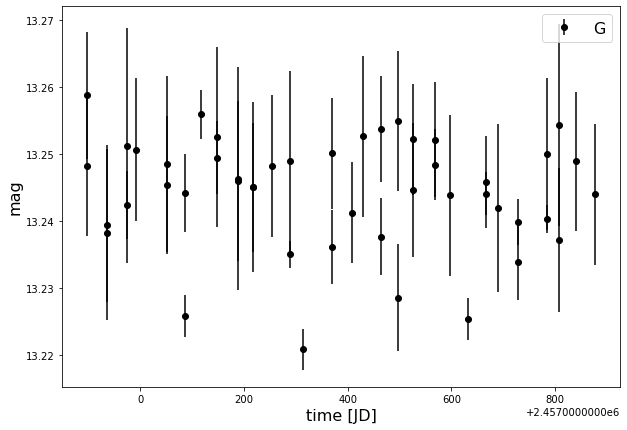

In [121]:
plot(gaia_lcs, 'G')

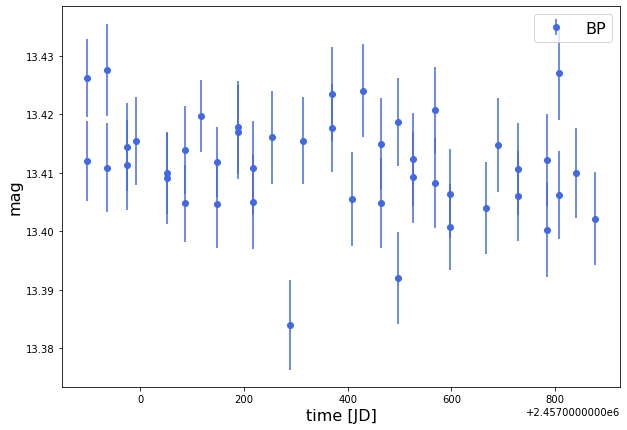

In [122]:
plot(gaia_lcs, 'BP')

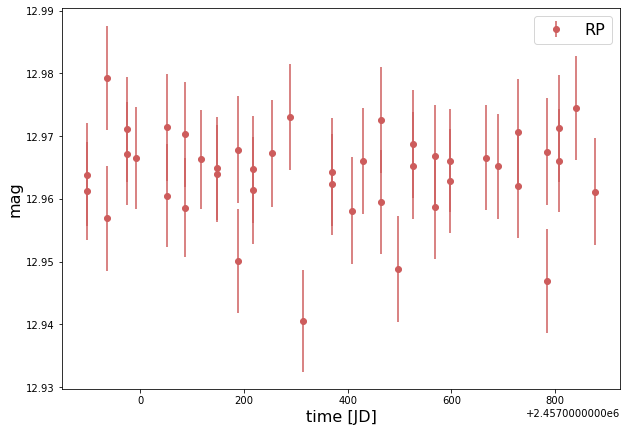

In [123]:
plot(gaia_lcs, 'RP')

In [26]:
def print_periodogram(lc, start_period, end_period):
    pg1_g = periodogram(lc, start_period, end_period)
    plot_periodogram(pg1_g)
    print(f'Frequency: {pg1_g.period[np.argmax(pg1_g.power)]}')

Frequency: 0.001 d


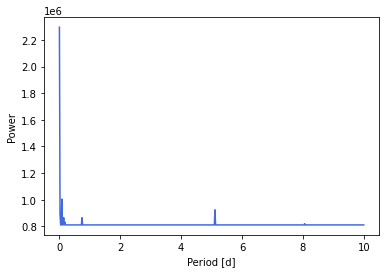

In [130]:
print_periodogram(gaia_lcs['G'], 0.001, 10.)

Frequency: 1.7556332665330663 d


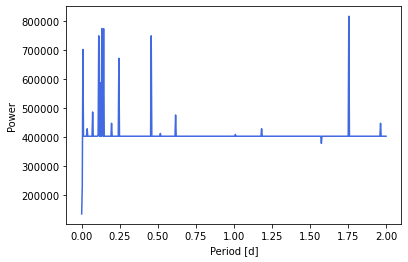

In [133]:
print_periodogram(gaia_lcs['BP'], 0.001, 2.)

Frequency: 0.017024048096192387 d


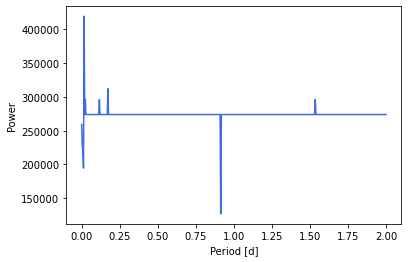

In [134]:
print_periodogram(gaia_lcs['RP'], 0.001, 2.)

## YSS

In [11]:
lightcurves = []
for file in list(glob.glob(f'{ROOT_PATH}/yss_*_phot.csv')):
    lightcurves.append(pd.read_csv(file))

In [16]:
lc = download_dr3_lightcurve([573941053907094144])

len['EPOCH_PHOTOMETRY-Gaia DR3 573941053907094144.xml'] lightcurves found.


In [18]:
gaia_lcs = get_gaia_bands(load_dr3_lightcurve(lc[0]))

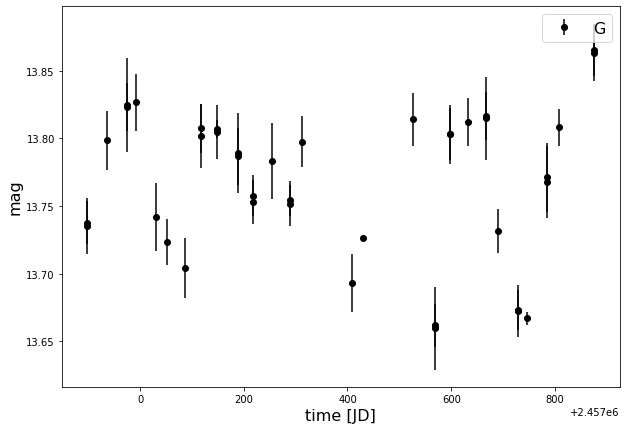

In [22]:
plot(gaia_lcs, 'G')

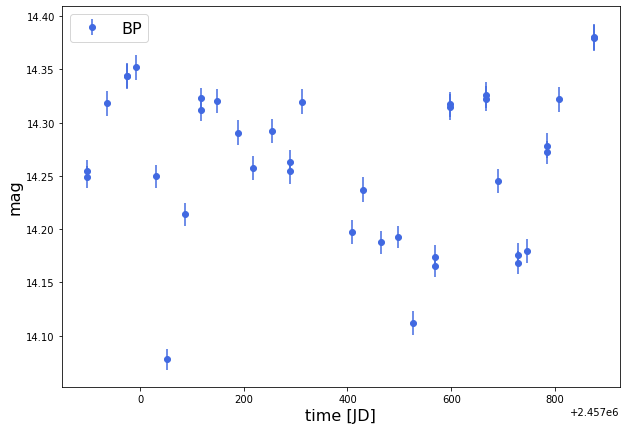

In [23]:
plot(gaia_lcs, 'BP')

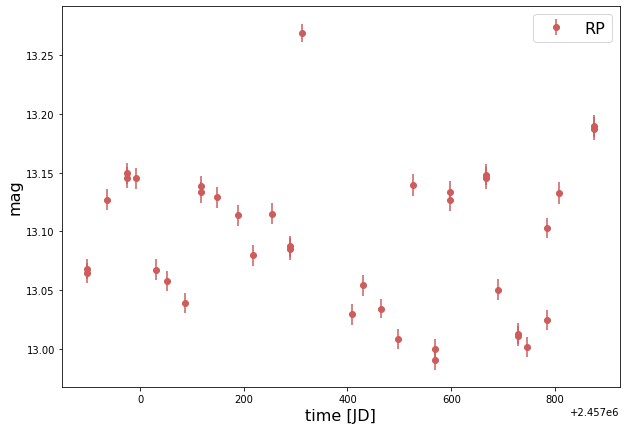

In [24]:
plot(gaia_lcs, 'RP')

Frequency: 0.4 d


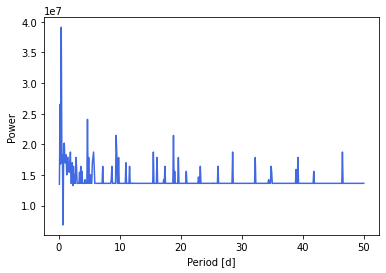

In [36]:
print_periodogram(gaia_lcs['G'], .1, 50.)

Frequency: 0.9509418837675352 d


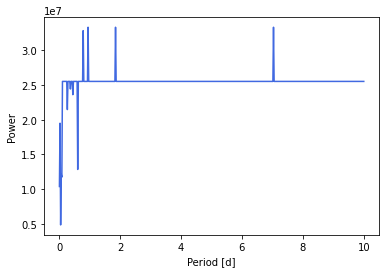

In [38]:
print_periodogram(gaia_lcs['RP'], 0.01, 10.)

Frequency: 0.5505410821643287 d


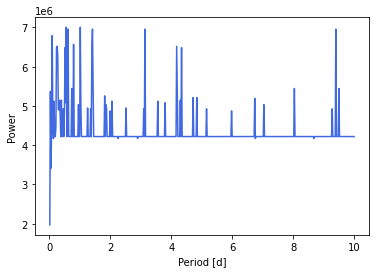

In [39]:
print_periodogram(gaia_lcs['BP'], 0.01, 10.)

In [40]:
gaia_lcs['G'].source_id[0]

573941053907094144

# TESS

In [42]:
import lightkurve as lk
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u

## BSS

In [65]:
tess_lc = lk.search_lightcurve(SkyCoord(ra=11.344*u.deg, dec=85.210635*u.deg,
                               frame=ICRS), radius=3*u.arcsec)

In [67]:
tess_lcs = tess_lc[0].download(flux_column='sap_flux')

In [68]:
from lightkurve.correctors import CBVCorrector

In [69]:
CBVCorrector(tess_lcs).correct().plot()

AssertionError: cbvCorrector expects light curve to be passed in e-/s units.

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

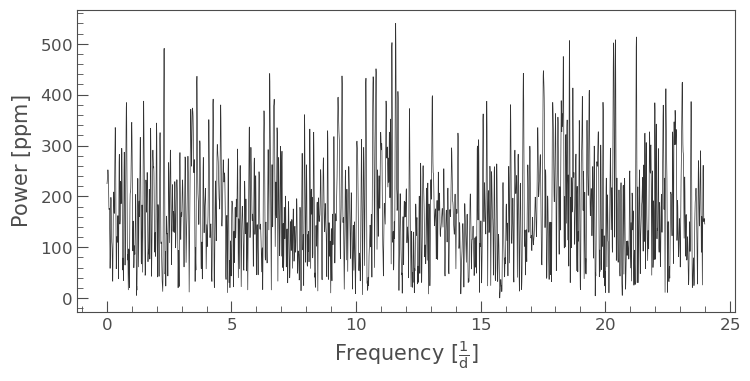

In [171]:
tess_lc[0].normalize(unit='ppm').to_periodogram().plot()

## YSS

In [150]:
with open(f'{ROOT_PATH}/yss_573952152102507904_tess.pickle', 'rb') as f:
    tess_lc = pickle.load(f)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

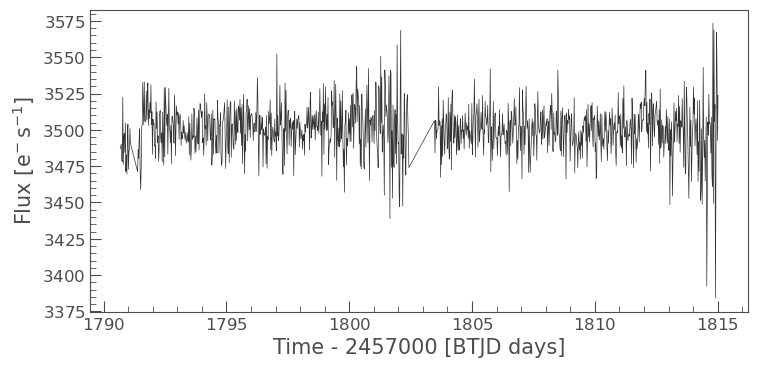

In [155]:
tess_lc[0].plot()

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

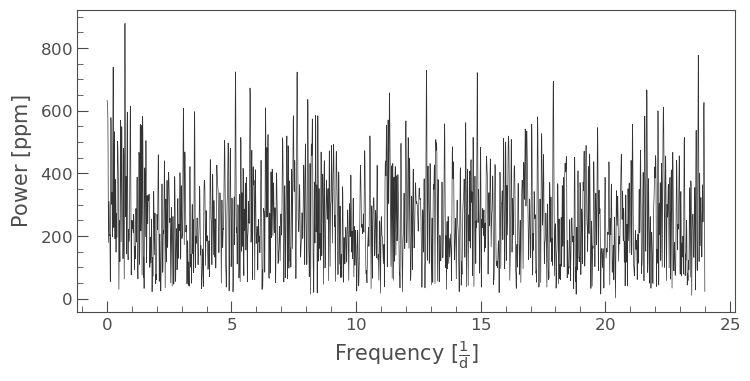

In [162]:
tess_lc[0].normalize(unit='ppm').to_periodogram().plot()